## Train & Test trading in China A stock market

### Import modules

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from IPython import display
display.set_matplotlib_formats("svg")

from meta import config
from meta.data_processors.qmt import Qmt, ReturnPlotter
from meta.env_stock_trading.env_stocktrading_China_A_shares import StockTradingEnv
from agents.stablebaselines3_models import DRLAgent
pd.options.display.max_columns = None

print("ALL Modules have been imported!")

ALL Modules have been imported!


### Create folders

In [5]:
import os

if not os.path.exists("./tensorboard_log"):
    os.makedirs("./tensorboard_log" )

### Download data, cleaning and feature engineering

In [6]:
ticket_list = ['600801.SH', '603985.SH', '600771.SH', '000831.SZ', '002230.SZ']

train_start_date='2020-12-04'
train_stop_date='2022-10-01'
val_start_date='2022-10-01'
val_stop_date='2022-10-31'

In [7]:
# download and clean
ts_processor = Qmt(data_source="tushare", 
                                   start_date=train_start_date,
                                   end_date=val_stop_date,
                                   time_interval="15m",
                                   csv_path='./dataset/15m')
ts_processor.download_data(ticker_list=ticket_list)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 58.23it/s]


Shape of DataFrame:  (37010, 8)


In [8]:
ts_processor.clean_data()
ts_processor.add_vix() # 默认使用 000001.SH
ts_processor.dataframe

Shape of DataFrame:  (37010, 8)


,tic,date,open,high,low,close,volume,day,vixy
0,000831.SZ,2020-12-04 09:45:00,14.06000,14.170000,13.94000,13.940000,23788.0,4,3426.689
1,002230.SZ,2020-12-04 09:45:00,38.90000,39.050000,38.55000,38.640000,39423.0,4,3426.689
2,600771.SH,2020-12-04 09:45:00,14.33000,14.410000,14.27000,14.390000,3887.0,4,3426.689
3,600801.SH,2020-12-04 09:45:00,22.22000,22.220000,21.98000,22.060000,7133.0,4,3426.689
4,603985.SH,2020-12-04 09:45:00,17.43787,17.692308,17.43787,17.568047,3335.0,4,3426.689
...,...,...,...,...,...,...,...,...,...
37005,000831.SZ,2022-10-28 13:30:00,30.03000,30.050000,30.01000,30.010000,635.0,4,2945.704
37006,002230.SZ,2022-10-28 13:30:00,34.36000,34.390000,34.35000,34.370000,1098.0,4,2945.704
37007,600771.SH,2022-10-28 13:30:00,26.86000,26.870000,26.83000,26.840000,363.0,4,2945.704
37008,600801.SH,2022-10-28 13:30:00,13.90000,13.900000,13.88000,13.880000,297.0,4,2945.704


In [9]:
# add_technical_indicator
ts_processor.add_technical_indicator(config.INDICATORS)
ts_processor.clean_data()
ts_processor.dataframe

tech_indicator_list:  ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
indicator:  macd
indicator:  boll_ub
indicator:  boll_lb
indicator:  rsi_30
indicator:  cci_30
indicator:  dx_30
indicator:  close_30_sma
indicator:  close_60_sma
Succesfully add technical indicators
Shape of DataFrame:  (37000, 17)


,tic,date,open,high,low,close,volume,day,vixy,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,000831.SZ,2020-12-04 10:15:00,14.040000,14.100000,13.960000,14.090000,12101.0,4,3421.702,0.004385,14.182016,13.871318,100.000000,57.894737,100.000000,14.026667,14.026667
1,002230.SZ,2020-12-04 10:15:00,38.310000,38.380000,38.100000,38.180000,42355.0,4,3421.702,-0.013441,38.850547,37.896119,0.000000,-85.156250,100.000000,38.373333,38.373333
2,600771.SH,2020-12-04 10:15:00,14.340000,14.350000,14.310000,14.320000,1383.0,4,3421.702,-0.002050,14.422111,14.277889,0.000000,-100.000000,100.000000,14.350000,14.350000
3,600801.SH,2020-12-04 10:15:00,22.040000,22.040000,21.950000,21.980000,8170.0,4,3421.702,-0.002432,22.109933,21.943400,0.000000,-100.000000,100.000000,22.026667,22.026667
4,603985.SH,2020-12-04 10:15:00,17.615385,17.650888,17.473373,17.538462,1540.0,4,3421.702,-0.000960,17.611930,17.516275,26.605505,-71.428571,100.000000,17.564103,17.564103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36995,000831.SZ,2022-10-28 13:30:00,30.030000,30.050000,30.010000,30.010000,635.0,4,2945.704,0.236419,30.243620,29.726380,60.056943,57.597777,19.563311,29.733000,28.899000
36996,002230.SZ,2022-10-28 13:30:00,34.360000,34.390000,34.350000,34.370000,1098.0,4,2945.704,-0.170788,35.973357,34.137643,46.247007,-131.001821,26.665012,35.166667,34.655833
36997,600771.SH,2022-10-28 13:30:00,26.860000,26.870000,26.830000,26.840000,363.0,4,2945.704,-0.557948,31.116379,25.837621,36.559545,-129.910100,47.185207,28.623667,28.264500
36998,600801.SH,2022-10-28 13:30:00,13.900000,13.900000,13.880000,13.880000,297.0,4,2945.704,-0.218623,15.197340,13.674660,25.633659,-150.800915,67.139399,14.538333,14.582500


In [10]:
technical_indicators = ['volume', 'vixy'] + config.INDICATORS
print(technical_indicators)

['volume', 'vixy', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']


### Split traning dataset

In [11]:
train_start_date='2020-12-04'
train_stop_date='2022-10-01'

In [12]:
train =ts_processor.data_split(ts_processor.dataframe, train_start_date, train_stop_date)       
len(train.tic.unique())

5

In [13]:
train.tic.unique()

array(['000831.SZ', '002230.SZ', '600771.SH', '600801.SH', '603985.SH'],
      dtype=object)

In [15]:
print(train.shape)

total_days = len(train.date.unique())
print(total_days)

(35830, 17)
7166


In [16]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension*(len(technical_indicators)+2+1)+1
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 66


## Train

In [44]:
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 200, 
    "initial_amount": 100000, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":1.0687e-3,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": technical_indicators, 
    "print_verbosity": 1,
    "initial_buy":True,
    "hundred_each_trade":True
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

initial_amount: 100000


In [45]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## A2C

In [46]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [65]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=total_days*2)

Logging to tensorboard_log/a2c/a2c_5
----------------------------------------
| time/                 |              |
|    fps                | 210          |
|    iterations         | 100          |
|    time_elapsed       | 2            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -13.7        |
|    explained_variance | 0.355        |
|    learning_rate      | 0.0007       |
|    n_updates          | 5833         |
|    policy_loss        | 1.91         |
|    reward             | -0.037367005 |
|    std                | 3.76         |
|    value_loss         | 0.0272       |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 213          |
|    iterations         | 200          |
|    time_elapsed       | 4            |
|    total_timesteps    | 1000         |
| train/                |              |
|    entropy_loss   

---------------------------------------
| time/                 |             |
|    fps                | 215         |
|    iterations         | 1400        |
|    time_elapsed       | 32          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -14.7       |
|    explained_variance | 0.711       |
|    learning_rate      | 0.0007      |
|    n_updates          | 7133        |
|    policy_loss        | 0.32        |
|    reward             | -0.04328846 |
|    std                | 4.61        |
|    value_loss         | 0.000711    |
---------------------------------------
Episode: 8
day: 7165, episode: 8
begin_total_asset: 100000.00
end_total_asset: 75721.72
total_reward: -24278.28
total_cost: 36816.03
total_trades: 35803
Sharpe: -0.119
----------------------------------------
| time/                 |              |
|    fps                | 215          |
|    iterations         | 1500         |
|    time_elapsed       | 34

--------------------------------------
| time/                 |            |
|    fps                | 214        |
|    iterations         | 2700       |
|    time_elapsed       | 62         |
|    total_timesteps    | 13500      |
| train/                |            |
|    entropy_loss       | -15.8      |
|    explained_variance | -0.887     |
|    learning_rate      | 0.0007     |
|    n_updates          | 8433       |
|    policy_loss        | -0.199     |
|    reward             | -0.0533264 |
|    std                | 5.71       |
|    value_loss         | 0.000556   |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 214          |
|    iterations         | 2800         |
|    time_elapsed       | 65           |
|    total_timesteps    | 14000        |
| train/                |              |
|    entropy_loss       | -15.9        |
|    explained_variance | -3.13        |
|    le

## Trade

In [66]:
val_start_date = "2022-10-01"
val_stop_date = "2022-10-31"

In [67]:
trade = ts_processor.data_split(ts_processor.dataframe, val_start_date, val_stop_date)
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 200, 
    "initial_amount": 100000, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":1.0687e-3,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": technical_indicators, 
    "print_verbosity": 1,
    "initial_buy":False,
    "hundred_each_trade":True
}
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

initial_amount: 100000


In [68]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym)

Episode: 2
day: 233, episode: 2
begin_total_asset: 100000.00
end_total_asset: 101102.06
total_reward: 1102.06
total_cost: 942.94
total_trades: 398
Sharpe: 0.274
hit end!


In [69]:
df_actions.to_csv("action.csv",index=True)
df_actions

,000831.SZ,002230.SZ,600771.SH,600801.SH,603985.SH
date,,,,,
2022-10-10 09:45:00,0,0,0,200,0
2022-10-10 10:00:00,0,0,0,0,0
2022-10-10 10:15:00,200,0,0,200,0
2022-10-10 10:30:00,0,0,0,0,0
2022-10-10 10:45:00,200,0,0,100,0
...,...,...,...,...,...
2022-10-28 10:45:00,0,-200,0,-200,0
2022-10-28 11:00:00,0,-200,0,-100,0
2022-10-28 11:15:00,0,-200,0,0,0


In [70]:
acc_value = df_account_value.values[:,1]
total_reward = acc_value[-1] - acc_value[0]
print("total_reward:", total_reward)

total_reward: 1102.0574688999332


## Backtest

In [71]:
# %matplotlib inline
plotter = ReturnPlotter(df_account_value, trade, val_start_date, val_stop_date)
# plotter.plot_all()

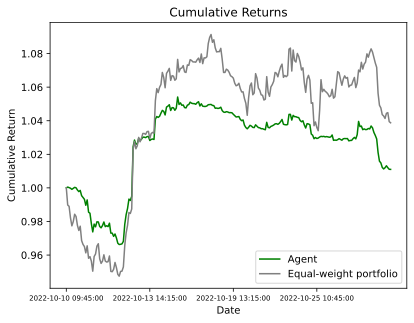

In [72]:
%matplotlib inline
plotter.plot(remove=0)

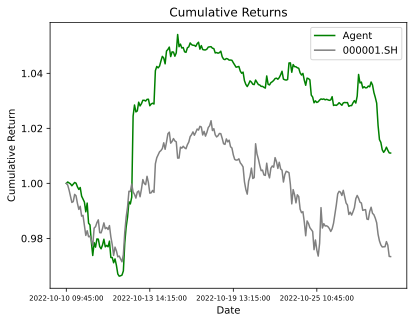

In [73]:
%matplotlib inline
plotter.plot('000001.SH', csv_path="dataset/", time_interval='15m', remove=0)